In [1]:
%matplotlib inline
import os
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
sns.set_style('ticks')
import toml
from matplotlib import colors
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
import pandas as pd

from modules.utils import load
from tasks.totaling import TotalizeCleansingWrtEval
from modules.plot import plot_filling_std, merge_line_legends

TensorFlow version 1.15.3 has been patched using tfdeterminism version 0.3.0


In [2]:
# output dir
out_dir = './results'
os.makedirs(out_dir, exist_ok=True)

In [3]:
# visual settings
legend_metrics = [
    'log_likelihood_kde',
    'log_inception_score',
    'fid',
    'if',
    'loss_d',
    'random',
    'metric_no_removal',
]

d_metric_rename_fig = dict((
    ('fid', 'Influence on FID (Ours)'),
    ('inception_score', 'Influence on IS (Ours)'),
    ('log_inception_score', 'Influence on IS (Ours)'),
    ('loss_d', 'Influence on Disc. Loss'),
    ('random', 'Random'),
    ('if', 'Isolation Forest'),
    ('metric_no_removal', 'No Removal'),
    ('if_data', 'Isolation Forest'),
    ('log_likelihood_kde', 'Influence on ALL (Ours)')
))

d_metric_rename_table = dict((
    ('fid', 'Influence on FID'),
    ('inception_score', 'Influence on IS'),
    ('log_inception_score', 'Influence on IS'),
    ('loss_d', 'Influence on D loss'),
    ('random', 'Random'),
    ('if', 'Isolation Forest'),
    ('metric_no_removal', 'No Removal'),
    ('if_data', 'Isolation Forest'),
    ('log_likelihood_kde', 'Influence on ALL')
))

d_metric_color = dict((
    ('fid', 'C0'),
    ('inception_score', 'C1'),
    ('log_inception_score', 'C1'),
    ('loss_d', 'C4'),
    ('random', 'C5'),
    ('if', 'C3'),
    ('metric_no_removal', 'grey'),
    ('if_data', 'C3'),
    ('log_likelihood_kde', 'C2'),
))

d_metric_marker = dict((
    ('fid', 'o'),
    ('inception_score', 'D'),
    ('log_inception_score', 'D'),
    ('loss_d', '>'),
    ('random', 'v'),
    ('if', '^'),
    ('metric_no_removal', ''),
    ('if_data', '^'),
    ('log_likelihood_kde', 's'),
))

d_metric_style = dict((
    ('fid', '-'),
    ('inception_score', '-'),
    ('log_inception_score', '-'),
    ('loss_d', '-'),
    ('random', '-'),
    ('if', '-'),
    ('metric_no_removal', '--'),
    ('if_data', '-'),
    ('log_likelihood_kde', '-'),
))


evalmetrics = [
    'fid',
    'inception_score',
    'log_likelihood_kde',
]

d_evalmetric_rename_table = dict((
    ('fid', 'FID'),
    ('inception_score', 'IS'),
    ('log_likelihood_kde', 'Average log-likelihood'),
))

d_evalmetric_rename_fig = dict((
    ('fid', 'Fréchet Inception Distance'),
    ('inception_score', 'Inception Score'),
    ('log_likelihood_kde', 'Average Log Likelihood'),
))

In [4]:
# load results and parameters
# these results can be loaded only after finishing the experiment command written in "Experiment 2: Data Cleansing" of README.md

conf_2d = toml.load(open('conf/2d_cleansing.toml', 'r'))
conf_mnist = toml.load(open('conf/mnist_cleansing.toml', 'r'))
task_2d = TotalizeCleansingWrtEval(**conf_2d[TotalizeCleansingWrtEval.__name__])
task_mnist = TotalizeCleansingWrtEval(**conf_mnist[TotalizeCleansingWrtEval.__name__])

dir_mnist = task_mnist.output().path
dir_2d = task_2d.output().path

d_evalmetric_pvals = dict((
    ('fid', load(os.path.join(dir_mnist, 'fid_ps_dict.pkl'))),
    ('inception_score', load(os.path.join(dir_mnist, 'inception_score_ps_dict.pkl'))),
    ('log_likelihood_kde', load(os.path.join(dir_2d, 'log_likelihood_kde_ps_dict.pkl')))
))

d_evalmetric_results = dict((
    ('fid', load(os.path.join(dir_mnist, 'fid_result_dic.pkl'))),
    ('inception_score', load(os.path.join(dir_mnist, 'inception_score_result_dic.pkl'))),
    ('log_likelihood_kde', load(os.path.join(dir_2d, 'log_likelihood_kde_result_dic.pkl')))
))

d_evalmetric_nsamp = dict((
    ('fid', conf_mnist['TotalizeCleansingWrtEval']['s_tr']),
    ('inception_score', conf_mnist['TotalizeCleansingWrtEval']['s_tr']),
    ('log_likelihood_kde', conf_2d['TotalizeCleansingWrtEval']['s_tr'])
))

d_evalmetric_removal_rates = dict((
    ('fid', conf_mnist['TotalizeCleansingWrtEval']['removal_rates']),
    ('inception_score', conf_mnist['TotalizeCleansingWrtEval']['removal_rates']),
    ('log_likelihood_kde', conf_2d['TotalizeCleansingWrtEval']['removal_rates'])
))

d_evalmetric_better_sign = {
    'fid': '+',
    'inception_score': '-',
    'log_likelihood_kde': '+'
}


In [5]:
def mylogfmt(x,pos):
    logx = np.log10(x) # to get the exponent
    return u"$10^{{{:.0f}}}$".format(logx)

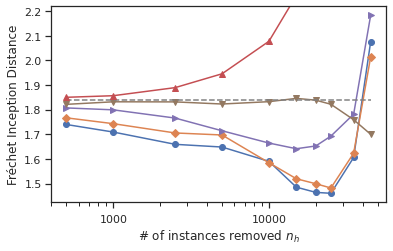

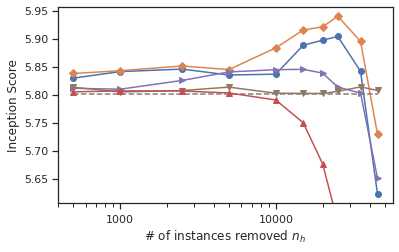

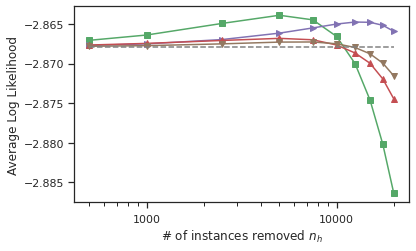

In [6]:
# figures
assert d_evalmetric_pvals.keys() == d_evalmetric_results.keys()
d_evalmetric_figs = {}
for evalmetric in evalmetrics:
    fig, ax = plt.subplots(figsize=(6, 4))
    xs = d_evalmetric_nsamp[evalmetric] * np.asarray(d_evalmetric_removal_rates[evalmetric])
    plot_filling_std(ax=ax,
                     xs=xs,
                     plots=d_evalmetric_results[evalmetric],
                     xlabel='# of instances removed $\it{n_{h}}$',
                     ylabel=d_evalmetric_rename_fig[evalmetric],
                     log_scale=True,
                     keys_ignored_by_autoscale='if',
                     loc_legend='lower left',
                     fill=False)
    fig.subplots_adjust(bottom=0.2)

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(mylogfmt))
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.get_legend().remove()

    for line in ax.lines:
        label = line.get_label()
        if label in d_metric_color:
            ydata = line.get_ydata()
            xdata = line.get_xdata()
            line.set_color(colors.to_rgba(d_metric_color[label]))
            line.set_label(d_metric_rename_fig[label])
            line.set_marker(d_metric_marker[label])
            line.set_linestyle(d_metric_style[label])

    d_evalmetric_figs[evalmetric] = fig

In [7]:
# adjust plot limits
ylim = d_evalmetric_figs['log_likelihood_kde'].axes[0].get_ylim()
ylim_ = (ylim[0] + 0.007, ylim[1])
d_evalmetric_figs['log_likelihood_kde'].axes[0].set_ylim(ylim_)

(-2.880499483655509, -2.862777021199648)

In [8]:
# save as pdf
for evalmetric, fig in d_evalmetric_figs.items():
    fig.savefig(os.path.join(out_dir, f'{evalmetric}_clean.pdf'))

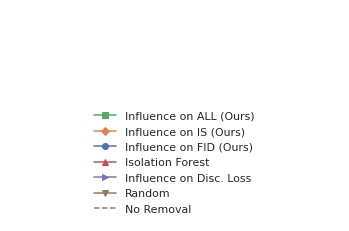

In [9]:
# collect lines in figs to make one legend figure
merge_line_legends(figs=d_evalmetric_figs.values(),
                   line_names=[d_metric_rename_fig[x] for x in legend_metrics],
                   out_path=os.path.join(out_dir, 'legend.pdf'))

In [10]:
# gen tables with p-values for latex
xdatas = []
for evalmetric in evalmetrics:
    txts_with_bold = OrderedDict()
    ns = [f'{x:.1f}k' for x in np.array(d_evalmetric_figs[evalmetric].axes[0].lines[0].get_xdata()/1000)]
    xdatas.append(ns)
    result = d_evalmetric_results[evalmetric]
    no_removal_vals = np.asarray(result.pop('metric_no_removal'))
    for metric, eval_metric_vals in result.items():
        ps = np.asarray(d_evalmetric_pvals[evalmetric][metric])
        means, stds = np.mean(eval_metric_vals-no_removal_vals, axis=0), np.std(eval_metric_vals-no_removal_vals, axis=0)
        if evalmetric == 'log_likelihood_kde':
            txts = [f'\thead{{{mean*100:+.2f} \\\\ ({std*100:.2f})}}' for no_removal_val, mean, std in zip(no_removal_vals, means, stds)]
        else:
            txts = [f'\thead{{{mean:+.2f} \\\\ ({std:.2f})}}' for no_removal_val, mean, std in zip(no_removal_vals, means, stds)]

        txts_with_bold[d_metric_rename_table[metric]] = [f'\textbf{{{txt}}}' if p < 0.05 and d_evalmetric_better_sign[evalmetric] in txt else txt for txt, p in zip(txts, ps)]

    df = pd.DataFrame(txts_with_bold, index=ns)
    # path_latex = os.path.join(out_dir, '{}_{}.txt'.format(val, metric))
    print(df.T.to_latex(escape=False))

\begin{tabular}{lllllllllll}
\toprule
{} &                     0.5k &                     1.0k &                              2.5k &                              5.0k &                             10.0k &                             15.0k &                             20.0k &                             25.0k &                             35.0k &                             45.0k \\
\midrule
Influence on FID    &  \thead{-0.10 \\ (0.13)} &  \thead{-0.13 \\ (0.18)} &           \thead{-0.18 \\ (0.28)} &           \thead{-0.19 \\ (0.46)} &           \thead{-0.25 \\ (0.45)} &           \thead{-0.36 \\ (0.35)} &           \thead{-0.38 \\ (0.36)} &           \thead{-0.38 \\ (0.37)} &           \thead{-0.23 \\ (0.46)} &           \thead{+0.23 \\ (0.60)} \\
Influence on IS     &  \thead{-0.07 \\ (0.10)} &  \thead{-0.10 \\ (0.14)} &           \thead{-0.14 \\ (0.22)} &           \thead{-0.14 \\ (0.37)} &           \thead{-0.26 \\ (0.28)} &           \thead{-0.32 \\ (0.29)} &           \thead{-0.